In [156]:
import gzip
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt

from PIL import Image
from argparse import ArgumentParser
from copy import deepcopy
from urllib.request import urlretrieve

In [157]:
SEED = 0
np.random.seed(SEED)


In [158]:
def unpickle(file):

    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def save_data(images, labels, dir, name, split, center):

    save_as = f"{name.lower()}_{split}_{center}.npz"
    np.savez(os.path.join(dir, save_as), 
                images=images,
                labels=labels)

In [159]:
root = "data/CIFAR10"
image_size = 32
number_of_labels = 10
patch_size = 4
labels = [i for i in range(number_of_labels)]

train_files = [f"data/CIFAR10/cifar-10-batches-py/data_batch_{i}" for i in range(1,6)]
test_file = "data/CIFAR10/cifar-10-batches-py/test_batch"

train_images = np.concatenate([unpickle(file)[b"data"] for file in train_files]).reshape(-1,3,32,32)
train_labels = np.concatenate([unpickle(file)[b"labels"] for file in train_files])

test_images = np.array(unpickle(test_file)[b"data"].reshape(-1,3,32,32))
test_labels = np.array(unpickle(test_file)[b"labels"])


In [160]:
from sklearn.model_selection import train_test_split

In [161]:
def shuffle(images, labels):
    n_samples = len(labels)
    shuffled_indices = np.random.permutation(n_samples)

    labels = labels[shuffled_indices]
    images = images[shuffled_indices]

    return images, labels

def get_shuffled_subset(images, labels, label_group, centers_per_group):
    mask = np.isin(element=labels, test_elements=label_group)

    subset_labels = labels[mask]
    subset_images = images[mask]
    subset_images, subset_labels = shuffle(subset_images, subset_labels)

    split_labels = np.array_split(subset_labels, centers_per_group)
    split_images = np.array_split(subset_images, centers_per_group)

    return split_images, split_labels

def add_color_patch(image, label, patch_size=3):

    tab10_colors = plt.cm.tab10.colors  # Returns RGB colors in [0, 1] range
    label_colors = {i: (np.array(tab10_colors[i]) * 255).astype(np.uint8) for i in range(10)}

    """Adds a 3x3 color patch determined by the label."""
    color = label_colors[label]
    # Modify the top-left corner of the image with the color patch
    for c in range(3):  # Iterate over channels (R, G, B)
        image[c, :patch_size, :patch_size] = color[c]
    return image


In [162]:
label_groups = [[0,1,2,3,4],[0,1,2,3,4],[5,6,7,8,9]]
# label_groups = [list(range(10)), list(range(10))]

centers_per_group = 5
dest_dir = 'data/CIFAR10/CIFAR10-LS'
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
else:
    print("Warning, existing files might be overwritten")

for i, label_group in enumerate(label_groups):
    split_train_images, split_train_labels = get_shuffled_subset(train_images, train_labels, label_group, centers_per_group)
    split_test_images, split_test_labels = get_shuffled_subset(test_images, test_labels, label_group, centers_per_group)

    for j, (imgs, lbls) in enumerate(zip(split_train_images, split_train_labels)):
        if i == 1:
            imgs = np.array([add_color_patch(img, lbl) for img, lbl in zip(imgs, lbls)]) # only add trigger to the second group

        X_train, X_val, y_train, y_val = train_test_split(imgs, lbls, test_size=0.1, random_state=SEED)
        X_train = X_train.transpose(0, 2, 3, 1)
        X_val = X_val.transpose(0, 2, 3, 1)
        center_num = i * centers_per_group + j
        save_data(X_train, y_train, dest_dir, "cifar10-ls", "train", center_num)
        save_data(X_val, y_val, dest_dir, "cifar10-ls", "val", center_num)
        print("center:", center_num, "train", len(y_train), "val", len(y_val))

    for j, (imgs, lbls) in enumerate(zip(split_test_images, split_test_labels)):
        imgs = np.array([add_color_patch(img, (lbl+1) % 5) for img, lbl in zip(imgs, lbls)]) # add offset trigger to all groups
        imgs = imgs.transpose(0, 2, 3, 1)
        center_num = i * centers_per_group + j
        save_data(imgs, lbls, dest_dir, "cifar10-ls", "test", center_num)
        print("center:", center_num, "test", len(lbls))

    


center: 0 train 4500 val 500
center: 1 train 4500 val 500
center: 2 train 4500 val 500
center: 3 train 4500 val 500
center: 4 train 4500 val 500
center: 0 test 1000
center: 1 test 1000
center: 2 test 1000
center: 3 test 1000
center: 4 test 1000
center: 5 train 4500 val 500
center: 6 train 4500 val 500
center: 7 train 4500 val 500
center: 8 train 4500 val 500
center: 9 train 4500 val 500
center: 5 test 1000
center: 6 test 1000
center: 7 test 1000
center: 8 test 1000
center: 9 test 1000
center: 10 train 4500 val 500
center: 11 train 4500 val 500
center: 12 train 4500 val 500
center: 13 train 4500 val 500
center: 14 train 4500 val 500
center: 10 test 1000
center: 11 test 1000
center: 12 test 1000
center: 13 test 1000
center: 14 test 1000


In [163]:
duplicated_label_groups = [group for group in label_groups for _ in range(centers_per_group)]

log = [[grp for grp in duplicated_label_groups], [grp for grp in label_groups]]
with open(os.path.join(dest_dir, "log.txt"), "w") as f:
    f.write(str(log))

In [164]:
X_train[0].shape

(32, 32, 3)

(array([0, 1, 2, 3, 4]), array([847, 865, 905, 954, 929]))


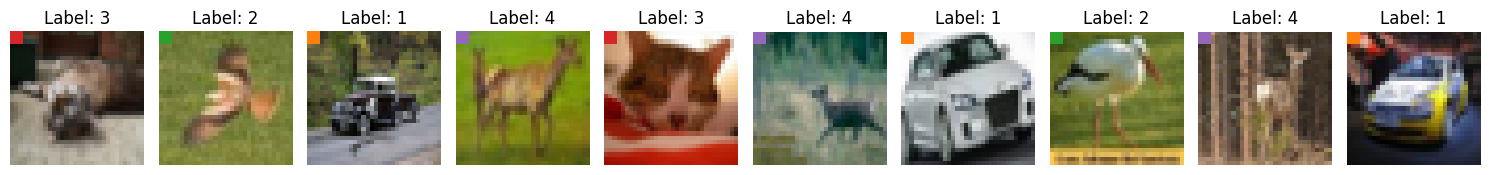

In [165]:
d = np.load('data/CIFAR10/CIFAR10-LS/cifar10-ls_train_6.npz')
# d = np.load('data/CIFAR10/rotcifar10hardmax10c/rotcifar10_test_0.npz')
images = d['images']
labels = d['labels']
print(np.unique(labels, return_counts=True))
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i in range(10,20):

    img = images[i]  # Convert from (3, 32, 32) to (32, 32, 3)
    axes[i % 10].imshow(img.astype('uint8'))
    axes[i % 10].axis('off')
    axes[i % 10].set_title(f"Label: {labels[i]}")

plt.tight_layout()
plt.show()